# Transfer learning - resnet34 on CIFAR-10

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import adabound # https://github.com/Luolc/AdaBound
from torchsummary import summary

# TorchCAM
from torchcam.utils import overlay_mask
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import SmoothGradCAMpp
from mpl_toolkits.axes_grid1 import ImageGrid

from torch.utils.tensorboard import SummaryWriter

# For notificaiton
import AppKit

Files already downloaded and verified
Files already downloaded and verified


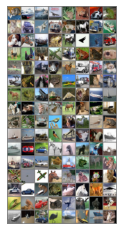

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 20
batch_size = 128
learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999
log_directory = f"runs/CIFAR10/resnet34/v1.0.1 Adam lr = {learning_rate}, epochs = {num_epochs}, batchsize ={batch_size}"
writer1  = SummaryWriter(log_directory)
#writer2 = SummaryWriter(log_directory)

# Loading dataset
# Since the dataset is in PIL (Python Imaging Library) form, tranform them into tensors of normalised range [-1, 1]
transform = transforms.Compose( # this transforms.compose combines multiple tranformations as one
    [
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

# The CIFAR10 tataset is avaliable in PyTorch
train_dataset = torchvision.datasets.CIFAR10(root='./cifar10Dataset', train=True,  download=True, transform=transform)
test_dataset  = torchvision.datasets.CIFAR10(root='./cifar10Dataset', train=False, download=True, transform=transform)

# Splitting the training and testing datasets into smaller batches
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

classes = ('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

# Checking a data sample 
example = iter(test_loader)
images, labels = example.next()

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

imshow(torchvision.utils.make_grid(images))

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading a model
model = torchvision.models.resnet34(pretrained=True)
num_features = model.fc.in_features     # Getting the number of features going into the fully connected layer

# Finetuning
for param in model.parameters():    # Freezing the startign layers
    # param.requires_grad = False
    param.requires_grad = True

model.fc = nn.Linear(num_features, 10)  # Redefining the layer with the same input features, but new output features (the amount of classes that we need to classify)
model.to(device)

#summary(model, (3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=[beta1, beta2], eps=1e-08) # Comment this if a model is loaded


In [5]:
# Training

# Tensorboard
writer1.add_graph(model, images)
writer1.close()

# Doing the training now
n_total_steps = len(train_loader)

running_loss = 0
running_correct = 0
running_loss_test = 0

steps_until_print = batch_size
#print(f'One batch has {len(example)/batch_size} images\nPrint every {steps_until_print}')

model.train()
for epoch in range(num_epochs):
    
    testing_batches = iter(test_loader) # For every epoch, we want to have tested the whole testing dataset once

    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimiser.zero_grad()   # Clear old gradient values
        loss.backward()         # Calculate the gradients
        optimiser.step()        # Update the model's weights (these are the model parameters(), different from hyperparameters)

        with torch.no_grad():
            # Add loss to the running loss 
            running_loss = loss.item()
            _, predictions = torch.max(outputs, 1)                  # Evaluate along the 1st dimension

            running_correct = (predictions == labels).sum().item()  # We can call .item() as it's a tensor with one item

            if (i+1) % 1 == 0: # Maybe replace 1 with steps_until_print
                # Logging the loss
                writer1.add_scalar('Loss/training', running_loss/steps_until_print, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step 
                # Adding the accuracy
                writer1.add_scalar('Accuracy/training', running_correct/batch_size*100, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step 

            # If for every 5 batches, test one batch. (test:train data ratio is split 1:5)
            if (i+1) % 5 == 0:  # Logging the testing loss
                test_images, test_labels = testing_batches.next()
                
                test_images = test_images.to(device)
                test_labels = test_labels.to(device)

                test_outputs = model(test_images)

                _, test_predictions = torch.max(test_outputs, 1)
                test_running_correct = (test_predictions == test_labels).sum().item()
                writer1.add_scalar('Accuracy/testing', test_running_correct/batch_size*100, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step 

                test_loss = criterion(test_outputs, test_labels)
                test_running_loss = test_loss.item()
                writer1.add_scalar('Loss/testing', test_running_loss/len(test_labels), epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step

    #writer2.add_scalar('Loss/training', running_loss/steps_until_print, epoch * n_total_steps) # label of the scalar, actual loss mean, current global step
    print(f'Epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.5f}')
    #print(f'Finished epoch {epoch+1}/{num_epochs}')

print("Training is done")
AppKit.NSBeep()

Epoch 1/20, step 391/391, loss = 0.65306
Epoch 2/20, step 391/391, loss = 0.62444
Epoch 3/20, step 391/391, loss = 0.39302


In [3]:
# Saving the model
# checkpoint = {
#     "epoch": 90,
#     "model_state": model.state_dict(),
#     "optimiser_state": optimiser.state_dict()
# }
# torch.save(checkpoint, "checkpoint_resnet34_80p_cifar.pth")

NameError: name 'model' is not defined